# Custom Everything with TPU
> Getting start to customize everything with TPU

- toc: true
- badges: true
- author: Austin Chen
- categories: [plant,classification,tpu,custom]


# 1% Better Everyday
- Add momentum to the custom optimizer

In [20]:
#hide

%%writefile conditional_cell_extension.py
def run_if(line, cell=None):
    '''Execute current line/cell if line evaluates to True.'''
    if not eval(line):
        return
    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the run_if magic when the extension loads.'''
    shell.register_magic_function(run_if, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the run_if magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['run_if']

Writing conditional_cell_extension.py


In [ ]:
#hide
%reload_ext conditional_cell_extension

In [21]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, re, datetime
import warnings, math, sys, json
import subprocess, pprint, pdb
from functools import partial

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from fastprogress.fastprogress import master_bar, progress_bar

warnings.simplefilter('ignore')
print(f"Using TensorFlow v{tf.__version__}")

Using TensorFlow v2.4.1


In [22]:
#hide
#@title Accelerator { run: "auto" }
DEVICE = 'TPU' #@param ["None", "'GPU'", "'TPU'"] {type:"raw", allow-input: true}

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTOTUNE = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.33.3.154:8470
initializing  TPU ...


INFO:tensorflow:Initializing the TPU system: grpc://10.33.3.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.33.3.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


> Tip: Adding seed helps reproduce results. Setting debug parameter wil run the model on smaller number of epochs to validate the architecture.

In [ ]:
#collapse-hide
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

GOOGLE = 'google.colab' in str(get_ipython())
KAGGLE = not GOOGLE

print("Running on {}!".format(
   "Google Colab" if GOOGLE else "Kaggle Kernel"
))

Running on Google Colab!


In [ ]:
#hide
#@title ML Lifecycle { run: "auto", display-mode: "form" }
SEED = 16
TRAIN = True #@param {type:"boolean"}

seed_everything(SEED)

In [ ]:
#hide
#%%run_if {GOOGLE}
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

In [ ]:
#hide
project_name = 'tpu-getting-started'
root_path  = '/content/gdrive/MyDrive/' if GOOGLE else '/'
input_path = f'{root_path}kaggle/input/{project_name}/'
working_path = f'{input_path}working/' if GOOGLE else '/kaggle/working/'
os.makedirs(working_path, exist_ok=True)
os.chdir(working_path)
os.listdir(input_path)

['working']

# Hyperparameters

In [ ]:
#@title {run: "auto", display-mode: "form" }

HEIGHT = 224#@param {type:"number"}
WIDTH = 224#@param {type:"number"}
CHANNELS = 3#@param {type:"number"}
IMG_SIZE = (HEIGHT, WIDTH, CHANNELS)
EPOCHS =  8#@param {type:"number"}
BATCH_SIZE = 8#@param {type:"raw"}
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

print("Input size: {}".format(IMG_SIZE))
print("Train on batch size of {} with {} replicas for {} epochs".format(
    BATCH_SIZE, strategy.num_replicas_in_sync, EPOCHS))

Input size: (224, 224, 3)
Train on batch size of 8 with 8 replicas for 8 epochs


# Data

## Loading data

In [ ]:
#hide
%%run_if {KAGGLE}
from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path(project_name)
GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
print(f"Sourcing images from")
for v in GCS_PATH_SELECT.values(): print(f"\t{v}")

In [ ]:
%%run_if {GOOGLE}
#@title {run: "auto", display-mode: "form"}
# reference: https://www.kaggle.com/austinyhc/custom-training-with-tpu?scriptVersionId=51687595
GCS_DS_PATH = 'gs://kds-cb0ae55850318491cbd1c07e21d98f26cb95151868fe65a3ce5ebe8e' #@param {type: "string"}
GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
print(f"Sourcing images from")
for v in GCS_PATH_SELECT.values(): print(f"\t{v}")

Sourcing images from
	gs://kds-cb0ae55850318491cbd1c07e21d98f26cb95151868fe65a3ce5ebe8e/tfrecords-jpeg-192x192
	gs://kds-cb0ae55850318491cbd1c07e21d98f26cb95151868fe65a3ce5ebe8e/tfrecords-jpeg-224x224
	gs://kds-cb0ae55850318491cbd1c07e21d98f26cb95151868fe65a3ce5ebe8e/tfrecords-jpeg-331x331
	gs://kds-cb0ae55850318491cbd1c07e21d98f26cb95151868fe65a3ce5ebe8e/tfrecords-jpeg-512x512


In [ ]:
#collapse-hide
CLASSES = ['pink primrose',        'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',
           'tiger lily',           'moon orchid',               'bird of paradise', 'monkshood',     'globe thistle',        
           'snapdragon',           "colt's foot",               'king protea',      'spear thistle', 'yellow iris',
           'globe-flower',         'purple coneflower',         'peruvian lily',    'balloon flower','giant white arum lily',
           'fire lily',            'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',
           'corn poppy',           'prince of wales feathers',  'stemless gentian', 'artichoke',     'sweet william',        
           'carnation',            'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',
           'ruby-lipped cattleya', 'cape flower',               'great masterwort', 'siam tulip',    'lenten rose',          
           'barberton daisy',      'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',
           'wallflower',           'marigold',                  'buttercup',        'daisy',         'common dandelion',     
           'petunia',              'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',
           'bishop of llandaff',   'gaura',                     'geranium',         'orange dahlia', 'pink-yellow dahlia',   
           'cautleya spicata',     'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy',
           'osteospermum',         'spring crocus',             'iris',             'windflower',    'tree poppy',           
           'gazania',              'azalea',                    'water lily',       'rose',          'thorn apple',
           'morning glory',        'passion flower',            'lotus',            'toad lily',     'anthurium',
           'frangipani',           'clematis',                  'hibiscus',         'columbine',     'desert-rose',
           'tree mallow',          'magnolia',                  'cyclamen ',        'watercress',    'canna lily',           
           'hippeastrum ',         'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',
           'camellia',             'mallow',                    'mexican petunia',  'bromelia',      'blanket flower',       
           'trumpet creeper',      'blackberry lily',           'common tulip',     'wild rose']

with strategy.scope():
    NCLASSES = len(CLASSES)
print(f"Number of labels: {NCLASSES}")

Number of labels: 104


In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1))
            for filename in filenames]
    return np.sum(n)

In [ ]:
def inspect_tfrecord(tfrec):
    raw_dataset = tf.data.TFRecordDataset(tfrec)
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
    print(example)

In [ ]:
train_filenames = tf.io.gfile.glob(GCS_PATH_SELECT[HEIGHT] + '/train/*.tfrec')
valid_filenames = tf.io.gfile.glob(GCS_PATH_SELECT[HEIGHT] + '/val/*.tfrec')
test_filenames  = tf.io.gfile.glob(GCS_PATH_SELECT[HEIGHT] + '/test/*.tfrec') 

In [ ]:
#hide-input
print("Number of train set: {}\n"
      "Number of valid set: {}\n"
      "Number of test set:  {}\n"
      .format(count_data_items(train_filenames),
              count_data_items(valid_filenames),
              count_data_items(test_filenames)))

Number of train set: 12753
Number of valid set: 3712
Number of test set:  7382



In [ ]:
inspect_tfrecord(train_filenames)

features {
  feature {
    key: "class"
    value {
      int64_list {
        value: 57
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "338ab7bac"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\000\340\000\340\003\001\021\000\002\021\001\003\021\001\377\304\000\035\000\000\002\003\001\001\001\001\001\000\000\000\000\000\000\000\000\005\006\004\007\010\003\002\001\t\000\377\304\000A\020\000\001\003\003\003

In [ ]:
def decode_image(image_string):
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, IMG_SIZE)
    return image

def read_tfrecord(example, labeled=True):
    TFREC_FORMAT = {
        "image" : tf.io.FixedLenFeature([],tf.string),
        "class" : tf.io.FixedLenFeature([],tf.int64),
        "id"    : tf.io.FixedLenFeature([],tf.string),
    } if labeled else {
        "image" : tf.io.FixedLenFeature([],tf.string),
        "id"    : tf.io.FixedLenFeature([],tf.string),
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32) if labeled else example['id']
    return image, label

## Data augmentation

In [23]:
#collapse-hide
def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [24]:
#collapse-hide
def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.uniform([1],dtype='float32') 
    width_shift = w_shift * tf.random.uniform([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape(tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [25]:
#collapse-hide
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [26]:
#collapse-show
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)    
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shift = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Flips
    if p_spatial >= .2:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
    
    if p_rotation >= .3: # Rotation
        image = transform_rotation(image, height=HEIGHT, rotation=45.)
    if p_shift >= .3: # Shift
        image = transform_shift(image, height=HEIGHT, h_shift=15., w_shift=15.)
    if p_shear >= .3: # Shear
        image = transform_shear(image, height=HEIGHT, shear=20.)
        
    # Crops
    if p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    elif p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
        
    # Pixel-level transforms
    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=0, upper=2)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=.8, upper=2)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.2)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)

    return image, label

In [27]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered: ignore_order.experimental_deterministic = False
    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    ds = ds.with_options(ignore_order)
    ds = ds.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return ds

def get_train_dataset(filenames):
    ds = load_dataset(filenames, labeled=True)
    ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(2048)
    ds = ds.batch(GLOBAL_BATCH_SIZE)
    # prefetch the next batch while training
    ds = ds.prefetch(AUTOTUNE)
    return ds
 
def get_valid_dataset(filenames, ordered=False):
    ds = load_dataset(filenames, labeled=True, ordered=ordered)
    ds = ds.batch(GLOBAL_BATCH_SIZE)
    ds= ds.cache()
    # prefetch the next batch while training
    ds = ds.prefetch(AUTOTUNE)
    return ds

def get_test_dataset(filenames, ordered=False): 
    ds = load_dataset(filenames, labeled=False, ordered=ordered)
    ds = ds.batch(GLOBAL_BATCH_SIZE)
    # prefetch the next batch while training
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [28]:
train_ds = get_train_dataset(train_filenames)
valid_ds = get_valid_dataset(valid_filenames)
test_ds  = get_test_dataset(test_filenames)

In [29]:
#collapse-show
def show_images(ds):
    _,axs = plt.subplots(3,3,figsize=(16,16))
    for ((x, y), ax) in zip(ds.take(9), axs.flatten()):
        ax.imshow((x.numpy()*255).astype(np.uint8))
        ax.set_title(CLASSES[y])
        ax.axis('off')

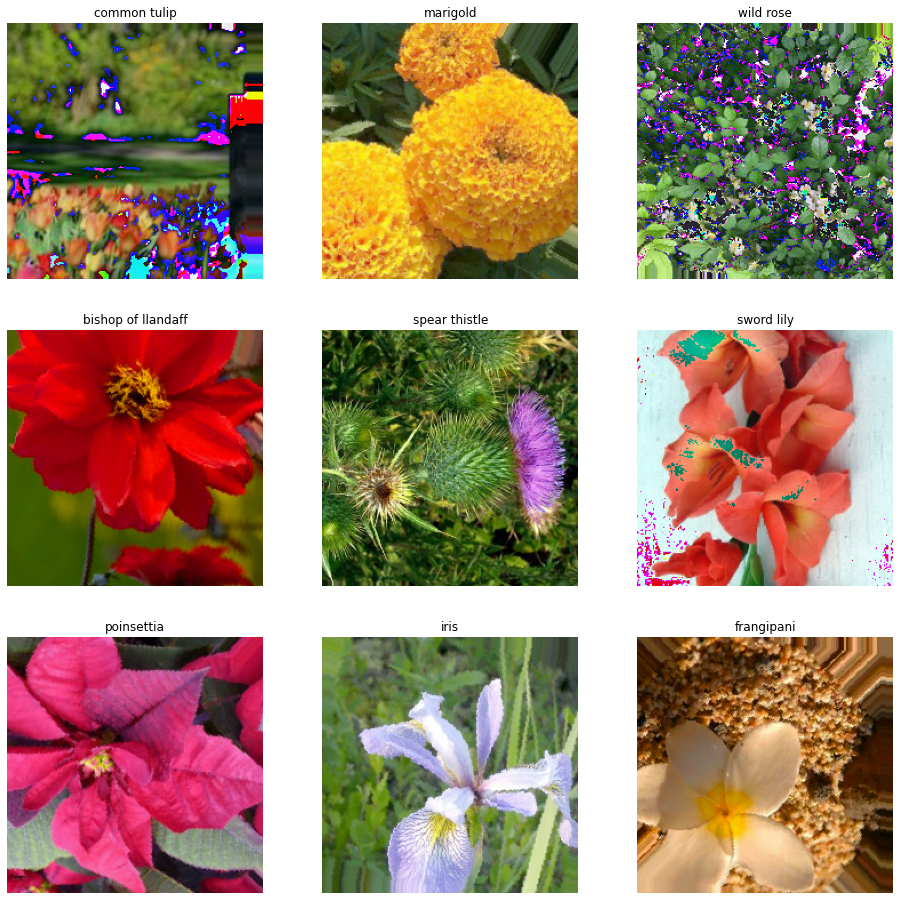

In [30]:
#hide
show_images(train_ds.unbatch())

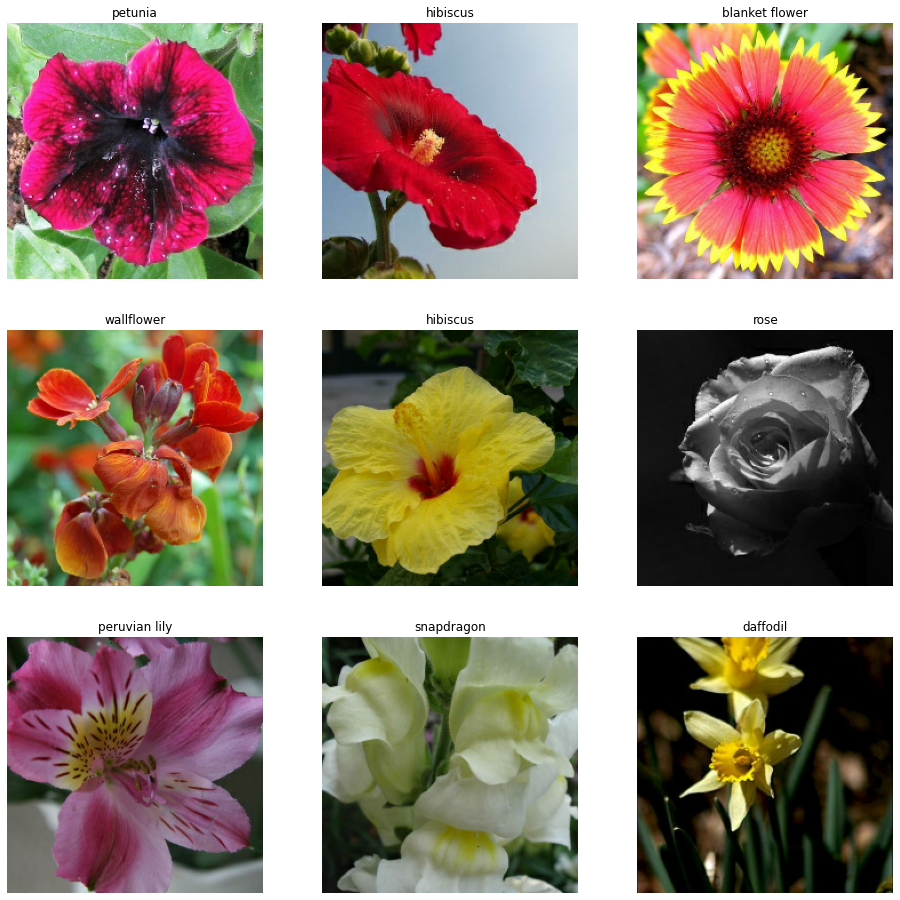

In [31]:
#hide
show_images(valid_ds.unbatch())

# Custom Model

In [32]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2

In [33]:
class Flower_Classifier(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.image_embedding_layers = []
        self.image_embedding_layers.append(
            Xception(weights='imagenet',
                     include_top=False,
                     input_shape=IMG_SIZE))
        self.image_embedding_layers.append(
            ResNet152V2(weights='imagenet',
                        include_top=False,
                        input_shape=IMG_SIZE))
        self.image_embedding_layers.append(
            InceptionResNetV2(weights='imagenet',
                              include_top=False,
                              input_shape=IMG_SIZE))
        self.pooling_layer = tf.keras.layers.GlobalAveragePooling2D()

        self.layer_normalization_layers = []
        self.prob_dist_layers = []
        for model_idx, image_embedded_layer in enumerate(self.image_embedding_layers):
            self.layer_normalization_layers.append(
                tf.keras.layers.LayerNormalization(epsilon=1E-6))
            self.prob_dist_layers.append(
                tf.keras.layers.Dense(NCLASSES, activation='softmax',
                                      name=f'prob_dist_{model_idx}'))

        kernel_init = tf.constant_initializer(
            np.array([0.86690587, 1.0948032, 1.1121726])) 
        bias_init = tf.constant_initializer(
            np.array([-0.13309559, 0.09480964, 0.11218266]))

        self.prob_dist_weight = tf.keras.layers.Dense(
            len(self.image_embedding_layers), activation="softmax",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
            name='prob_dist_weight')

    def call(self, inputs, training=False):
        all_model_outputs=[]
        for i in range(len(self.image_embedding_layers)):
            embedding = self.image_embedding_layers[i](inputs, training=training)
            pooling = self.pooling_layer(embedding, training=training)
            pooling_normalized = self.layer_normalization_layers[i](pooling, training=training)
            model_output = self.prob_dist_layers[i](pooling_normalized, training=training)
            all_model_outputs.append(model_output)

        all_model_outputs = tf.stack(all_model_outputs, axis=1)
        prob_dist_weight = self.prob_dist_weight(tf.constant(1, shape=(1,1)), training=training)
        prob_dist = tf.linalg.matmul(prob_dist_weight, all_model_outputs)
        prob_dist = prob_dist[:, 0, :]
        return prob_dist

    def model(self):
        x = tf.keras.Input(shape=IMG_SIZE)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [34]:
with strategy.scope():
    model = Flower_Classifier()

219062272/219055592 [==============================] - 3s 0us/step


> Note: There is a workaround to show `summary()` of a subclassing model which is introduced in [this video](https://youtu.be/WcZ_1IAH_nM?list=PLhhyoLH6IjfxVOdVC1P1L5z5azs0XjMsb&t=1124).

> Warning: Using this might casue a problem that the model goes outside of the scope. Will figure out a workaround for this.

In [35]:
#model.model().summary()

# Custom Optimizer Schedule

In [36]:
class CustomCyclicSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, n_step, lr_max, div=25.0, div_final=1e5,
                 pct_start=0.25, staircase=False, cycle=False):
        self.lr_start = lr_max / div
        self.lr_max = lr_max
        self.lr_min = lr_max / div_final
        self.rising_steps = int(n_step * pct_start)
        self.rising_a = (lr_max-self.lr_min) / (self.rising_steps-1)
        self.rising_b = self.lr_min

        self.falling_steps = int(n_step - self.rising_steps)
        self.falling_rate = self.lr_min / lr_max
        self.cycle = tf.constant(cycle, dtype=tf.bool)
        self.decay_fn = tf.keras.experimental.CosineDecay(
            initial_learning_rate = lr_max,
            decay_steps = self.falling_steps,
            alpha = self.lr_min)

    def __call__(self, step):
        """ `step` is actually the step index, starting at 0. """
        lr = tf.cond(step < self.rising_steps,
                     lambda : self.rising_a*tf.cast(step, tf.float32) + self.rising_b,
                     lambda : self.decay_fn(tf.cast(step-self.rising_steps, tf.int32)))
        return tf.cast(lr, tf.float32)
    

8 total epochs and 200 steps per epoch


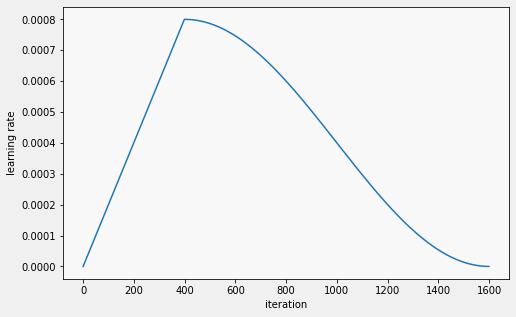

In [37]:
#@title One-Cycle Scheduler {display-mode: "form", run: "auto"}
NSTEPS = math.ceil(count_data_items(train_filenames) / GLOBAL_BATCH_SIZE) * EPOCHS
LR_MAX = 1e-4 #@param {type: "number"}
LR_MAX *= strategy.num_replicas_in_sync
DIV = 25.0 #@param {type: "number"}
DIV_FINAL = 1e5 #@param {type: "number"}
PCT_START = 0.25#@param {type: "number"}

with strategy.scope():
    schedule = CustomCyclicSchedule(
        n_step=NSTEPS,
        lr_max=LR_MAX,
        div=DIV,
        div_final=DIV_FINAL,
        cycle=False)

xps = tf.range(NSTEPS)
yps = [schedule(x) for x in xps]
fig,ax = plt.subplots(1,1,figsize=(8,5),facecolor='#F0F0F0')
ax.plot(xps, yps)
ax.set_facecolor('#F8F8F8')
ax.set_xlabel('iteration')
ax.set_ylabel('learning rate')

print('{:d} total epochs and {:d} steps per epoch'
        .format(EPOCHS, NSTEPS // EPOCHS))

In [38]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(schedule)

## Custom Loss Function

> Note: About why we set `reduction` to `'none'`, please check this [tutorial](https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function). In particular, read the paragraph. If using `tf.keras.losses` classes (as in the example below), the loss reduction needs to be explicitly specified to be one of `NONE` or `SUM`. `AUTO` and `SUM_OVER_BATCH_SIZE` are disallowed when used with `tf.distribute.Strategy`.

> Note: About why we use `tf.nn.compute_average_loss`, please check this [tutorial](https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function)

> Warning: While trained with `BATCH_SIZE = 8 * strategy.num_replicas_in_sync`, I got `nan` values. Since we pass probability distribution to `CategoricalCrossentropy` with `from_logits = False`, which has numerical unstability issue, we use the same trick in the source code to avoid such unstabiltiy

In [39]:
from tensorflow.python.ops import clip_ops
from tensorflow.python.framework import constant_op

In [40]:
def _constant_to_tensor(x, dtype):
    return constant_op.constant(x, dtype=dtype)

with strategy.scope():
    loss_object = tf.keras.losses.CategoricalCrossentropy(
                from_logits=False, reduction='none', label_smoothing=0.1)
    def loss_function(labels, prob_dists, sample_weights=1.0):
        epsilon_ = _constant_to_tensor(tf.keras.backend.epsilon(), prob_dists.dtype.base_dtype)
        prob_dists = clip_ops.clip_by_value(prob_dists, epsilon_, 1 - epsilon_)
        labels = tf.keras.backend.one_hot(labels, NCLASSES)
        loss = loss_object(labels, prob_dists)
        loss = tf.nn.compute_average_loss(loss, global_batch_size=BATCH_SIZE)
        return loss

## Custom Metric Function

In [41]:
def get_metrics(name):
    loss = tf.keras.metrics.Mean(name=f'{name}_loss', dtype=tf.float32)
    acc = tf.keras.metrics.SparseCategoricalAccuracy(name=f'{name}_acc', dtype=tf.float32)
    return loss, acc

with strategy.scope():
    train_loss_obj, train_acc_obj = get_metrics('train')
    valid_loss_obj, valid_acc_obj = get_metrics('valid')

## Custom Training Loop

The default runtime in TensorFlow 2.0 is eager execution. As such, our training loop above executes eagerly. This is great for debugging, but graph compilation has a definite performace advantage. Describing your computation as a static graph enables the framework to apply global performance optimizations.

### Train Step

In [42]:
train_input_signature = [
    tf.TensorSpec(shape=(None, None, None, None), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
]

@tf.function(input_signature=train_input_signature)
def train_step(images, labels):
    with tf.GradientTape() as tape:
        prob_dists = model(images, training=True)
        loss = loss_function(labels, prob_dists)

    grads = tape.gradient(loss, model.trainable_variables)
    grads, global_norm = tf.clip_by_global_norm(grads, clip_norm=1.0)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    train_acc_obj(labels, prob_dists)
    return loss

@tf.function
def distributed_train_step(inputs):
    (images, labels) = inputs
    per_replica_losses = strategy.run(train_step, args=(images, labels))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

In [50]:
#https://www.tensorflow.org/guide/distributed_training
train_dist_ds = strategy.distribute_datasets_from_function(
        lambda _: (get_train_dataset(train_filenames)
                    .take(10*strategy.num_replicas_in_sync)))

metrics_names = ['train_loss','train_acc'] 
pb_i = tf.keras.utils.Progbar(10, width=15, stateful_metrics=metrics_names)

train_loss_obj.reset_states()
train_acc_obj.reset_states()
train_iter = iter(train_dist_ds)

for _ in range(10):
    train_loss = distributed_train_step(next(train_iter))
    train_loss_obj(train_loss)
    values=[('train_loss', train_loss_obj.result()),
            ('train_acc',train_acc_obj.result())]
    pb_i.add(1, values=values)

ResourceExhaustedError: ignored

### Valid step

In [ ]:
valid_input_signature = train_input_signature

@tf.function(input_signature=valid_input_signature)
def valid_step(images, labels):
    prob_dists = model(images, training=False)
    loss = loss_function(labels, prob_dists, sample_weights=None)
    valid_acc_obj(labels, prob_dists)
    return loss

@tf.function
def distributed_valid_step(inputs):
    (images, labels) = inputs
    per_replica_losses = strategy.run(valid_step, args=(images, labels))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

### Test step

In [ ]:
test_input_signature = [
    tf.TensorSpec(shape=(None, None, None, None), dtype=tf.float32)]
    
@tf.function(input_signature=test_input_signature)
def test_step(images):
     prob_dists = model(images, training=False)
     return prob_dists

@tf.function
def distributed_test_step(inputs):
    images = inputs
    prob_dists = strategy.run(test_step, args=(images,))
    return prob_dist

### Training loop

In [ ]:
from tensorflow.keras.utils import Progbar
import time 
import numpy as np

metrics_names = ['train_acc','train_loss','valid_acc','valid_loss'] 

num_epochs = 5
num_training_samples = 100
batch_size = 10

for i in range(num_epochs):
    #print("\nepoch {}/{}".format(i+1,num_epochs))
    pb_i = Progbar(num_training_samples, width=15, stateful_metrics=metrics_names)

    for j in range(int(num_training_samples//batch_size/2)):
        time.sleep(0.3)
        values=[('train_acc',np.random.random(1)), ('train_loss',np.random.random(1))]
        pb_i.add(batch_size, values=values)

    for j in range(int(num_training_samples//batch_size/2)):
        time.sleep(0.3)
        values=[('valid_acc',np.random.random(1)), ('valid_loss',np.random.random(1))]
        pb_i.add(batch_size, values=values)

100/100 [===============] - 3s 30ms/step - train_acc: 0.8709 - train_loss: 0.1034 - valid_acc: 0.8521 - valid_loss: 0.1586


In [ ]:
DEBUG = True
def fit():
    valid_dist_ds = strategy.distribute_datasets_from_function(
        lambda _: get_valid_dataset(train_filenames, ordered=True))
    if DEBUG: valid_ist_ds = valid_dist_ds.take(10)

    #test_dist_ds = strategy.distribute_datasets_from_function(
    #    lambda _: get_test_dataset(test_filenames, ordered=True)
    #                    .map(lambda im,lbl: im))
    
    for epoch in range(EPOCHS):
        metrics_names = ['train_acc','train_loss','valid_acc','valid_loss'] 
        pb_i = Progbar(num_training_samples, width=15, stateful_metrics=metrics_names)

        train_dist_ds = strategy.distribute_datasets_from_function(
            lambda _: get_train_dataset(train_filenames))
        if DEBUG:
            train_dist_ds = train_dist_ds.take(10)
            valid_dist_ds = valid_dist_ds.take(10)

        train_loss_obj.reset_states()
        train_acc_obj.reset_states()
        valid_loss_obj.reset_states()
        valid_acc_obj.reset_states()

        for ibatch, inputs in enumerate(train_dist_ds):
            train_loss = distributed_train_step(inputs)
            train_loss_obj(train_loss)

        history['train_loss'].append(train_loss_obj.result())
        history['train_acc'].append(train_acc_obj.result())

        for ibatch, inputs in enumerate(valid_dist_ds):
            valid_loss = distributed_valid_step(inputs)
            valid_loss_obj(valid_loss)

        history['valid_loss'].append(valid_loss_obj.result())
        history['valid_acc'].append(valid_acc_obj.result())

In [ ]:
fit()

In [ ]:
%%run_if {False}
train_loss_obj.reset_states()
train_acc_obj.reset_states()

steps_per_epoch = NSTEPS // EPOCHS
train_iterator = iter(train_dataset)

mb = master_bar(range(EPOCHS))
mb.names = ['lr']
for epoch in mb:
    step_start = epoch * steps_per_epoch
    step_end = (epoch+1) * steps_per_epoch
    for step in progress_bar(range(step_start, step_end), parent=mb):
        train_step(train_iterator)
        mb.child.comment = f'second bar stat'
        
    mb.main_bar.comment = f'first bar stat'
    mb.write('Epoch {}: training loss: {}, accuracy: {}%'.format(
      epoch, round(float(train_loss_obj.result()), 4),
      round(float(train_acc_obj.result()) * 100, 2)))
    train_loss_obj.reset_states()
    train_acc_obj.reset_states()

In [ ]:
#%%run_if {False}
#cm_trues = (valid_ds.map(lambda im,lbl: lbl)
#                    .unbatch()
#                    .batch(count_data_items(valid_filenames))
#                    .as_numpy_iterator()
#                    .next())

In [ ]:
# cm_preds = np.argmax(all_valid_preds, axis=-1)
# f1 = f1_score(cm_trues, cm_preds,
#               labels=range(NCLASSES), average='macro')
# precision = precision_score(cm_trues, cm_preds,
#               labels=range(NCLASSES), average='macro')
# recall = recall_score(cm_trues, cm_preds,
#               labels=range(NCLASSES), average='macro')    

# history['valid_f1'].append(f1)        
# history['valid_precision'].append(precision)
# history['valid_recall'].append(recall)
# history['model_coefs'].append(flower_classifier.prob_dist_weight(tf.constant(1, shape=(1, 1))).numpy()[0])